### **Задание №1**. Предположим, что у вас в базе есть табличка с балансом по всем счетам клиента на конец дня. Из-за особенностей построения таблицы, часть значений незаполнена и физически это означает отсутствие информации об изменении баланса. Для простоты будем считать, пропущенные значения для одного пользователя не могут встретиться между двумя заполненными. Напишите SQL запрос для заполнения неизвестных значений по каждому клиенту последним известным.

client_id |date | value
--- | --- | ---
1 | 14.04.2020 | 10000
1 | 15.04.2020 | 5000
1 | 16.04.2020 | NaN
1 | 17.04.2020 | NaN
1 | 18.04.2020 | NaN
2 | 14.04.2020 | 250000
2 | 15.04.2020 | 250000
2 | 16.04.2020 | 230000
2 | 17.04.2020 | 230000
2 | 18.04.2020 | 225000
3 | 14.04.2020 | 50000
3 | 15.04.2020 | NaN
3 | 16.04.2020 | NaN
3 | 17.04.2020 | NaN
3 | 18.04.2020 | NaN


In [ ]:
# Выводим последнее значение игнорируя NULL, с помощью функции LAST_VALUE. 
# Так же используем оконную функцию OVER (PARTITION BY) для группировки по client_id.
SELECT 
  client_id, date,
  LAST_VALUE(value IGNORE NULLS) OVER (PARTITION BY client_id ORDER BY date) AS filled_value
FROM 
  account_balance
ORDER BY 
  client_id, date;

### **Задание №1.1 (*)**. В прошлом задании мы считали, что пропущенные значения не могут находиться между двумя заполненными в рамках одного пользователя, что не всегда правда в реальных задачах. Напишите теперь SQL запрос без указанного допущения.

client_id |date | value
--- | --- | ---
1 | 14.04.2020 | 10000
1 | 15.04.2020 | 5000
1 | 16.04.2020 | NaN
1 | 17.04.2020 | 7000
1 | 18.04.2020 | NaN
2 | 14.04.2020 | 250000
2 | 15.04.2020 | 250000
2 | 16.04.2020 | 230000
2 | 17.04.2020 | 230000
2 | 18.04.2020 | 225000
3 | 14.04.2020 | 50000
3 | 15.04.2020 | NaN
3 | 16.04.2020 | NaN
3 | 17.04.2020 | 49000
3 | 18.04.2020 | NaN

In [ ]:
# Функция COALESCE возвращает значение value. В случае NULL, LAG возвращает последнее известное значение для client_id.
SELECT 
  client_id, date,
  COALESCE(value, LAG(value IGNORE NULLS) OVER (PARTITION BY client_id ORDER BY date)) AS filled_value
FROM 
  account_balance
ORDER BY 
  client_id, date;

### **Задание №2**. Пусть клиенты обладают рядом статусов, закодированных цифрами: 0 - "улица", 1 - "зарплатник", 2 - "премиум", 3 - "пенсионер", 4 - "студент". У нас есть матрица с логами смен статусов за некоторый период, разверните ее в матрицу статус - статус с частотами перехода между ними.

Пример, как было:

client_id | prev_segment | new_segment|
--- | --- | ---
1 | 0 | 1
2 | 0 | 2
3 | 4 | 3

Пример, как нужно:

segment |0 | 1 | 2 | 3 | 4 
--- | --- | --- | --- | --- | ---
0 | 0 | 0.5 | 0.5 | 0 | 0 
1 | 0 |0 | 0 | 0 | 0
2 | 0 | 0 | 0 | 0 | 0
3 | 0 | 0 | 0 | 0 | 0
4 | 0 | 0 | 0 | 1 | 0

В процессе выполнения задания разрешается пользоваться библиотеками numpy и pandas.

In [ ]:
import numpy as np
import pandas as pd

# Сгенерируем данные для задачи
data = pd.DataFrame(
    np.random.randint(low=0, high=5, size=(50000000, 2)),
    columns=['prev_segment', 'new_segment']
)

In [ ]:
data.loc[(data.prev_segment == 0) & (data.new_segment == 0)].shape

(2000948, 2)

In [ ]:
# Чтобы найти частоту перехода из одной группы в другую нужно разделить
# количество переходов из prev_segment в new_segment на общее количество из prev_segment
trans_counts = data.groupby(['prev_segment', 'new_segment']).size()
prev_counts = data['prev_segment'].value_counts()

In [ ]:
seg_trans = {}

for segment in range(prev_counts.shape[0]):
# Проходим по каждому статусу и находим отношение переходов в new_segment к общему числу из segment
    seg_trans_counts = trans_counts[segment] / prev_counts[segment]
    seg_trans[segment] = seg_trans_counts

df = pd.DataFrame(seg_trans)
df = df.rename_axis('segment')

print(df)

                0         1         2         3         4
segment                                                  
0        0.200069  0.199997  0.199921  0.199976  0.199986
1        0.200070  0.200249  0.200216  0.199978  0.200034
2        0.199963  0.199812  0.199897  0.199842  0.199739
3        0.200104  0.200010  0.200204  0.200040  0.200080
4        0.199795  0.199932  0.199762  0.200164  0.200161


Решение через матрицу

In [ ]:
logs = data.to_numpy()
logs.shape

(50000000, 2)

In [ ]:
status_matrix = np.zeros((5, 5))

In [ ]:
for row in logs:
    # Проходим по каждой паре последовательных статусов в строке
    for i in range(len(row) - 1):
        # Увеличиваем элемент в матрице статус-статус
        from_status = row[i]
        to_status = row[i+1]
        status_matrix[from_status, to_status] += 1

# Нормализуем матрицу статус-статус
status_matrix = status_matrix / np.sum(status_matrix, axis=1, keepdims=True)

print(status_matrix)

[[0.20006861 0.20006971 0.19996252 0.20010431 0.19979485]
 [0.19999664 0.2002493  0.19981249 0.20000954 0.19993202]
 [0.19992141 0.20021577 0.19989692 0.20020427 0.19976164]
 [0.19997585 0.19997815 0.19984191 0.20003997 0.20016411]
 [0.19998578 0.20003427 0.19973866 0.20008026 0.20016103]]


### **Задание №2.1 (*)**. Если вы не пользовались библиотечными функциями и реализовывали алгоритм самостоятельно, напишите, пожалуйста, его асимптотическую сложность в терминах O-большое.

In [ ]:
# Для матричного способа решения этой задачи асимптотическая сложность будет зависеть от числа строк (m) и столбцов (n) в матрице logs.
# Таким образом сложность равна O(m*n), в нашем случае O(50000000 * 2)
# В pandas решении cложность будет зависеть от количества статусов клиентов, в нашем случае O(5)

### **Задание №3**. Постройте прогнозую модель для датасета с UCI Machine Learning: предобработайте категориальные фичи, отберите их, соберите схему валидации и отберите модели с помощью нее. Описание датасета по ссылке: https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

Данная задача multilabel multiclass classification, поэтому предлагаю начать с одного из подходов:
- Свести задачу к multilabel binary classification, как это указано в описании к датасету;
- Свести задачку к binary classification тем или иным способом;
- Обучить множество multiclass/binary classification моделей;
- Что-то еще, что придет в голову.


In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data

--2023-02-27 03:17:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346695 (339K) [application/x-httpd-php]
Saving to: ‘drug_consumption.data’

drug_consumption.da 100%[===================>] 338.57K  --.-KB/s    in 0.1s    

2023-02-27 03:17:16 (3.10 MB/s) - ‘drug_consumption.data’ saved [346695/346695]



In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.3 MB/s eta 0:00:00


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 13.9 MB/s eta 0:00:00


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.9 MB/s eta 0:00:00


In [ ]:
import time
import warnings
warnings.filterwarnings('ignore')

import optuna
import shap

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('max_columns', None)

columns = [
    'Age','Gender','Education','Country','Ethnicity','Nscore','Escore','Oscore','Ascore',
    'Cscore','Impulsive','SS','Alcohol','Amphet','Amyl','Benzos','Caff','Cannabis','Choc','Coke',
    'Crack','Ecstasy','Heroin','Ketamine','Legalh','LSD','Meth','Mushrooms','Nicotine','Semer','VSA'
]

data = pd.read_csv('drug_consumption.data', header=None, index_col=0)
data.columns = columns
data.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL5,CL2,CL0,CL2,CL6,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL5,CL2,CL2,CL0,CL6,CL4,CL6,CL3,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL6,CL0,CL0,CL0,CL6,CL3,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL4,CL0,CL0,CL3,CL5,CL2,CL4,CL2,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL4,CL1,CL1,CL0,CL6,CL3,CL6,CL0,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [ ]:
# Так как у нас в категориальных признаках присутствует порядок применим Label encoder
for i in columns[12:]:
  data[i] = data[i].map({"CL0": 0, "CL1": 1, "CL2": 2, "CL3": 3, "CL4": 4, "CL5": 5, "CL6": 6})

In [ ]:
# Cведем задачу к бинарной классификации
for i in columns[12:]:
  data[i] = data[i].apply(lambda x: 1 if (x >= 2) else 0)

In [ ]:
data.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,1,1,1,0,1,1,1,1,0,1,0,1,0,1,1,0,1,0,0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,1,0,0,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,1,0,0


In [ ]:
data.isna().sum().sum()

0

In [ ]:
data[data.duplicated()].count().sum()

0

In [ ]:
round(data[data.columns[12:]].sum()/len(data)*100, 1).sort_values(ascending=False)

Choc         98.1
Caff         98.0
Alcohol      96.4
Nicotine     67.1
Cannabis     67.1
Benzos       40.8
Legalh       40.4
Ecstasy      39.8
Mushrooms    36.8
Coke         36.4
Amphet       36.0
LSD          29.5
Meth         22.1
Amyl         19.6
Ketamine     18.6
VSA          12.2
Heroin       11.2
Crack        10.1
Semer         0.3
dtype: float64

Практически все из выборки имеют зависимость к шоколаду, кофеину и алкоголю. И практически нет Semer зависимых. Предсказывать эти признаки в представленном датасете не имеет смысла.

<AxesSubplot:>

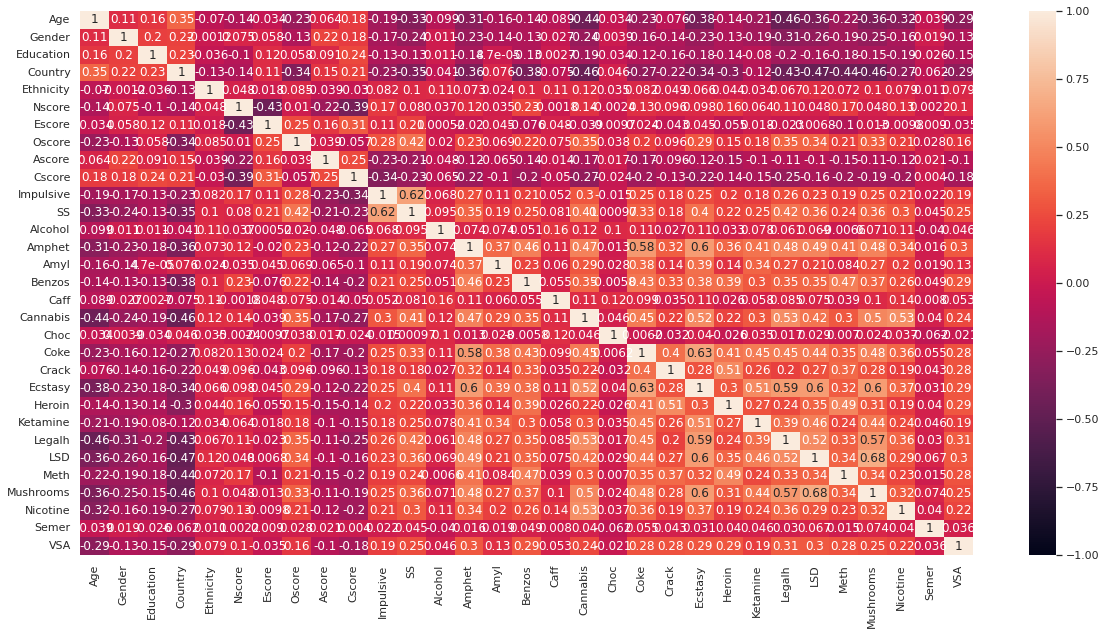

In [ ]:
sns.set()
corr = data.corr()
plt.figure(figsize=(20,10), facecolor = 'white')
sns.heatmap(corr, annot=True, vmin=-1)

Многие наркотики имеют корреляцию между собой

In [ ]:
# Объединим признаки crack и coke так как можно сказать что это похожие виды наркотика
data['Cocaine'] = data[["Coke", "Crack"]].apply(lambda x: 1 if (x == 1).any() else 0, axis=1)

In [ ]:
data.drop(['Coke', "Crack", "Semer", "Choc", "Caff", "Alcohol"], axis = 1, inplace = True)

In [ ]:
def data_preprocessing(df, column, non_scale = False):
    df = df.copy()
 # Разбиваем выборку   
    X = df.drop(column, axis=1)
    y = df[column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify= y, random_state= 777)

# Возвращаем значения с нормировкой или без
    if non_scale:
      return X_train, X_test, y_train, y_test
    else: 
      # Выполняем нормировку данных
      scaler = StandardScaler()
      scaler.fit(X_train)
    
      X_train = pd.DataFrame(scaler.transform(X_train), 
                             index=X_train.index, 
                            columns=X_train.columns)
      X_test = pd.DataFrame(scaler.transform(X_test), 
                            index=X_test.index, 
                            columns=X_test.columns)
      
      return X_train, X_test, y_train, y_test

In [ ]:
# Функция построения confusion matrix
def plot_confusion_matrix(y,y_predict):
    cm = confusion_matrix(y, y_predict)
    fig=plt.figure(figsize=(6,4), facecolor= 'white')
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues');
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 

In [ ]:
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=777),
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=777),
    "LGBM": LGBMClassifier(random_state=777),
    "CatBoost": CatBoostClassifier(random_state=777, verbose=False),
}

LR_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
    'max_iter': [50, 100, 150]
}

KNN_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'p': [1, 2]
}

RF_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [4, 6, 8, 10, 12]
}

boosted_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.05, 0.1, 0.15]
}

grid = {
    "LogisticRegression": LR_grid,
    "KNN": KNN_grid,
    "RandomForest": RF_grid,
    "LGBM": boosted_grid,
    "CatBoost": boosted_grid,
}

In [ ]:
# Cоздаем двухуровневый датафрейм 
index = pd.MultiIndex.from_product([data.columns[12:], classifiers.keys()],
                                                         names=['Drug', 'Classifier'])
valid_scores = pd.DataFrame({
    'Validation accuracy': np.zeros(len(index)),
    'F1-score_train': np.zeros(len(index)),
    'F1-score_test': np.zeros(len(index)),
    'Training time': np.zeros(len(index))
}, index=index)

for col in data.columns[12:]:

    # Разбиваем выборку и нормируем внутри функции
    X_train, X_test, y_train, y_test = data_preprocessing(data, col)

    for i, (key, classifier) in enumerate(classifiers.items()):
        start = time.time()

        print("Целевой признак:", col)
        print('Модель:', key)

        clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=3)

        # Обучаем модель 
        clf.fit(X_train, y_train)
        # Находим лучшую модель с помощью GridSearchCV
        best_clf = clf.best_estimator_
        
        # Делаем предсказания
        y_train_pred = best_clf.predict(X_train)
        y_pred = best_clf.predict(X_test)
        y_pred_prob = best_clf.predict_proba(X_test)

        # Записываем метрики в датафрейм
        valid_scores.loc[(col, key), 'Validation accuracy'] = clf.score(X_test, y_test)
        valid_scores.loc[(col, key), 'F1-score_train'] = f1_score(y_train, y_train_pred)
        valid_scores.loc[(col, key), 'F1-score_test'] = f1_score(y_test, y_pred)

        # Фиксируем время обучения
        stop = time.time()
        valid_scores.loc[(col, key), 'Training time'] = np.round((stop - start), 2)

        # Cоздаем глобальные переменные для дальнейших наблюдений
        var_name = f"{col}_params_{key}"
        globals()[var_name] = col

        param_value = {
            "X_train" : X_train,
            "X_test" : X_test,
             "y_test": y_test,
             "y_pred": y_pred,
             "pred_proba": best_clf.predict_proba,
             "best_params": clf.best_params_,
              "best_clf": best_clf
              }
        globals()[var_name] = param_value
        

        print('f1-score train:',   np.round(f1_score(y_train, y_train_pred), 2))
        print('f1-score test:',   np.round(f1_score(y_test, y_pred), 2))
        print('Время обучения (сек):', np.round((stop - start), 2))
        print('---------------------------------------------')

Целевой признак: Amphet
Модель: LogisticRegression
f1-score train: 0.77
f1-score test: 0.76
Время обучения (сек): 2.03
---------------------------------------------
Целевой признак: Amphet
Модель: KNN
f1-score train: 0.8
f1-score test: 0.75
Время обучения (сек): 1.45
---------------------------------------------
Целевой признак: Amphet
Модель: RandomForest
f1-score train: 1.0
f1-score test: 0.75
Время обучения (сек): 37.8
---------------------------------------------
Целевой признак: Amphet
Модель: LGBM
f1-score train: 0.81
f1-score test: 0.74
Время обучения (сек): 20.8
---------------------------------------------
Целевой признак: Amphet
Модель: CatBoost
f1-score train: 0.83
f1-score test: 0.77
Время обучения (сек): 76.88
---------------------------------------------
Целевой признак: Amyl
Модель: LogisticRegression
f1-score train: 0.56
f1-score test: 0.54
Время обучения (сек): 0.59
---------------------------------------------
Целевой признак: Amyl
Модель: KNN
f1-score train: 0.64
f1-

In [ ]:
# Cмотрим средний скор для всех признаков
valid_scores.groupby(level='Classifier').mean()

,Validation accuracy,F1-score_train,F1-score_test,Training time
Classifier,,,,
CatBoost,0.849192,0.841779,0.699066,84.697857
KNN,0.831777,0.767760,0.677391,1.367857
LGBM,0.845406,0.820064,0.699523,22.121429
LogisticRegression,0.847804,0.741969,0.701530,0.965000
RandomForest,0.847678,0.926726,0.688382,33.817143


In [ ]:
round(data[data.columns[12:]].sum()/len(data)*100, 1).sort_values(ascending=False)

Cannabis     67.1
Nicotine     67.1
Benzos       40.8
Legalh       40.4
Ecstasy      39.8
Cocaine      37.1
Mushrooms    36.8
Amphet       36.0
LSD          29.5
Meth         22.1
Amyl         19.6
Ketamine     18.6
VSA          12.2
Heroin       11.2
dtype: float64

In [ ]:
valid_scores.loc[['Heroin', 'VSA', "Ketamine"]]

Validation accuracy  F1-score_train  \
Drug     Classifier                                                
Heroin   LogisticRegression             0.902827        0.685315   
         KNN                            0.895760        0.625954   
         RandomForest                   0.909894        0.786765   
         LGBM                           0.909894        0.750000   
         CatBoost                       0.913428        0.789474   
VSA      LogisticRegression             0.862191        0.458333   
         KNN                            0.869258        0.570342   
         RandomForest                   0.867491        0.967949   
         LGBM                           0.862191        0.709434   
         CatBoost                       0.867491        1.000000   
Ketamine LogisticRegression             0.855124        0.649123   
         KNN                            0.826855        0.762887   
         RandomForest                   0.860424        1.000000   
         LGBM                           0.849823        0.777293   
         CatBoost                       0.860424        0.696682   

                             F1-score_test  Training time  
Drug     Classifier                                        
Heroin   LogisticRegression       0.521739           0.65  
         KNN                      0.477876           1.20  
         RandomForest             0.504854          37.76  
         LGBM                     0.556522          21.60  
         CatBoost                 0.505051          90.56  
VSA      LogisticRegression       0.250000           1.64  
         KNN                      0.314815           2.20  
         RandomForest             0.157303          29.17  
         LGBM                     0.277778          23.96  
         CatBoost                 0.210526          83.53  
Ketamine LogisticRegression       0.594059           1.31  
         KNN                      0.519608           1.56  
         RandomForest             0.577540          42.88  
         LGBM                     0.564103          29.73  
         CatBoost                 0.577540          88.49

Все модели склонны к переобучению. LGBM, LogisticRegression и KNN показали себя лучше всего.

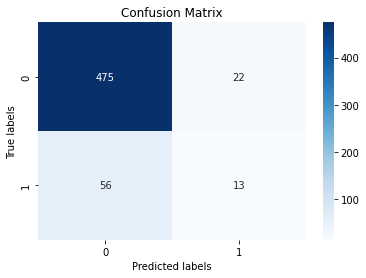

In [ ]:
plot_confusion_matrix(VSA_params_LogisticRegression['y_test'], VSA_params_LogisticRegression['y_pred'])

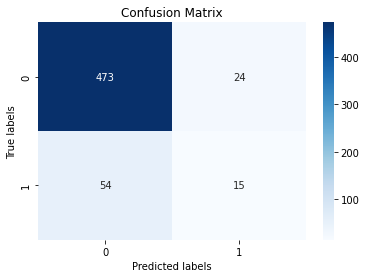

In [ ]:
plot_confusion_matrix(VSA_params_LGBM['y_test'], VSA_params_LGBM['y_pred'])

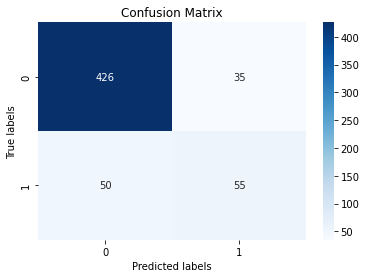

In [ ]:
plot_confusion_matrix(Ketamine_params_LGBM['y_test'], Ketamine_params_LGBM['y_pred'])

Модели хорошо определяют отсутствие наркотической зависимости у несбалансированных классов

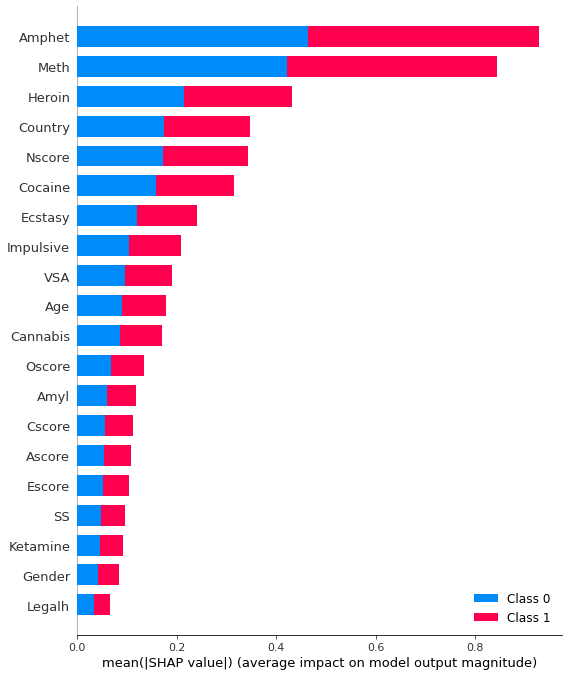

In [ ]:
Benzos_LGBM_explainer = shap.TreeExplainer(Benzos_params_LGBM['best_clf'])
Benzos_LGBM_shap_values = Benzos_LGBM_explainer.shap_values(Benzos_params_LGBM['X_train'])
shap.summary_plot(Benzos_LGBM_shap_values, Benzos_params_LGBM['X_train'])

In [ ]:
Benzos_LogisticRegression_explainer = shap.Explainer(
    Benzos_params_LogisticRegression['pred_proba'],
    Benzos_params_LogisticRegression['X_train']
    )

Benzos_LogisticRegression_shap_values = Benzos_LogisticRegression_explainer(
    Benzos_params_LogisticRegression['X_train']
    )

Permutation explainer: 1320it [01:55, 10.49it/s]                          


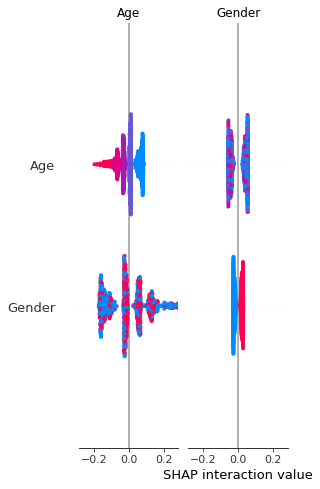

In [ ]:
shap.summary_plot(
    Benzos_LogisticRegression_shap_values,
    Benzos_params_LogisticRegression['X_train'],
    feature_names=Benzos_params_LogisticRegression['X_train'].columns
)

In [ ]:
Benzos_KNN_explainer = shap.Explainer(
    Benzos_params_KNN['pred_proba'],
     Benzos_params_KNN['X_train']
     )

Benzos_KNN_shap_values = Benzos_KNN_explainer(Benzos_params_KNN['X_train'])

Permutation explainer: 1320it [27:44,  1.26s/it]


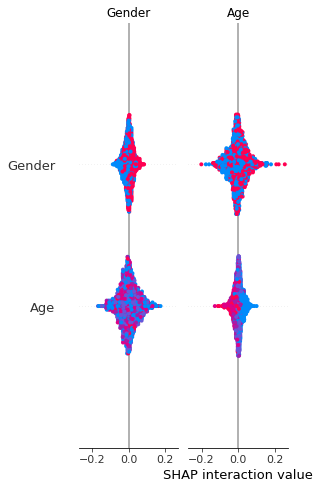

In [ ]:
shap.summary_plot(
    Benzos_KNN_shap_values,
    Benzos_params_KNN['X_train'],
    feature_names=Benzos_params_KNN['X_train'].columns
)

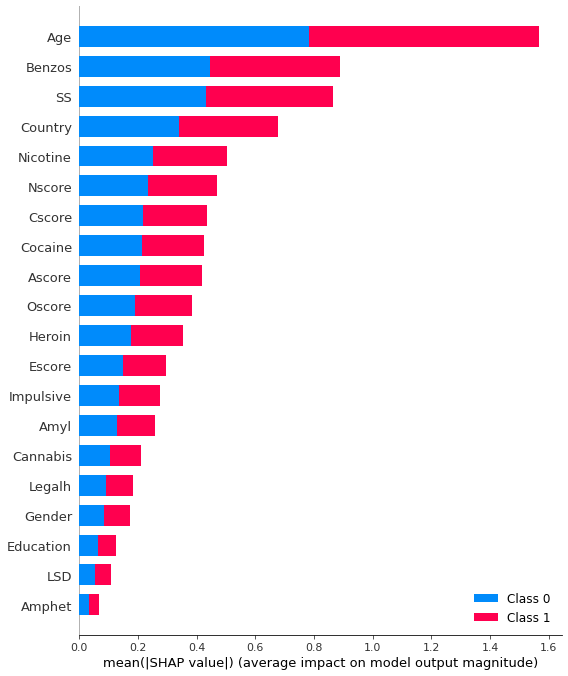

In [ ]:
VSA_LGBM_explainer = shap.TreeExplainer(VSA_params_LGBM['best_clf'])
VSA_LGBM_shap_values = VSA_LGBM_explainer.shap_values(VSA_params_LGBM['X_train'])
shap.summary_plot(VSA_LGBM_shap_values, VSA_params_LGBM['X_train'])

Для сбалансированного класса Benzos и для несбалансированного класса VSA модели выбирают различные признаки по важности, поэтому отсеять "шумовые" мы не можем

In [ ]:
Benzos_LGBM_error_index = np.where(
    Benzos_params_LGBM['y_test'] != Benzos_params_LGBM['y_pred'])[0]
    
print(Benzos_LGBM_error_index)

[  1   7  10  16  23  32  34  39  41  49  52  55  58  59  68  71  82  83
  87  89  91 108 121 123 128 130 145 148 152 153 154 167 169 170 173 177
 190 197 200 202 205 222 228 233 235 240 243 248 268 274 275 287 288 291
 294 295 300 301 307 310 329 330 332 339 341 347 351 352 356 362 376 383
 389 397 399 411 433 444 445 452 453 458 459 465 467 470 474 482 489 508
 511 518 521 526 529 536 538 539 540 541 545 546 551 555 556 557 561 564]


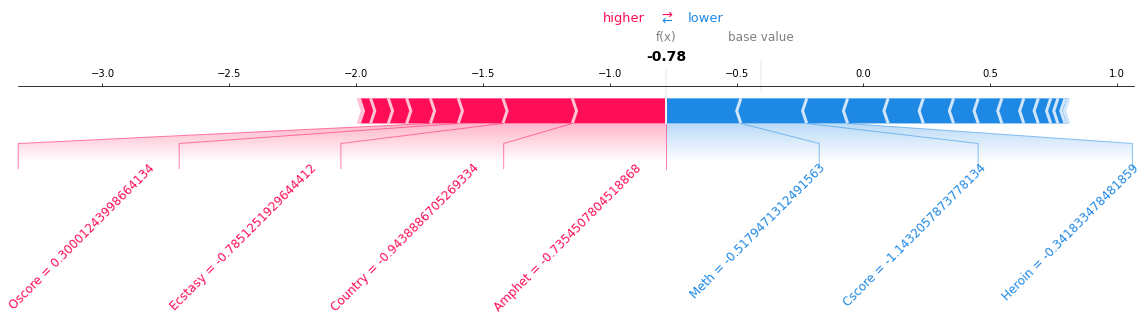

In [ ]:
# Влияние признаков для одного ошибочно классифицированного объекта
shap.force_plot(
    Benzos_LGBM_explainer.expected_value[1],
    Benzos_LGBM_shap_values[1][Benzos_LGBM_error_index[2]],
    Benzos_params_LGBM['X_test'].iloc[[Benzos_LGBM_error_index[2]]],
    text_rotation=45,
    matplotlib = True
    )

In [ ]:
 VSA_LGBM_error_index = np.where(
     VSA_params_LGBM['y_test'] != VSA_params_LGBM['y_pred'])[0]
     
print( VSA_LGBM_error_index)

[ 11  22  37  40  41  43  44  53  76  89  90  98 102 115 121 122 123 142
 146 147 156 160 170 172 179 183 190 192 193 201 204 210 213 214 219 221
 230 233 243 251 259 268 270 280 287 296 302 306 318 321 346 347 359 372
 380 388 393 400 406 416 420 423 426 450 455 456 463 464 470 471 485 487
 521 525 529 550 552 556]


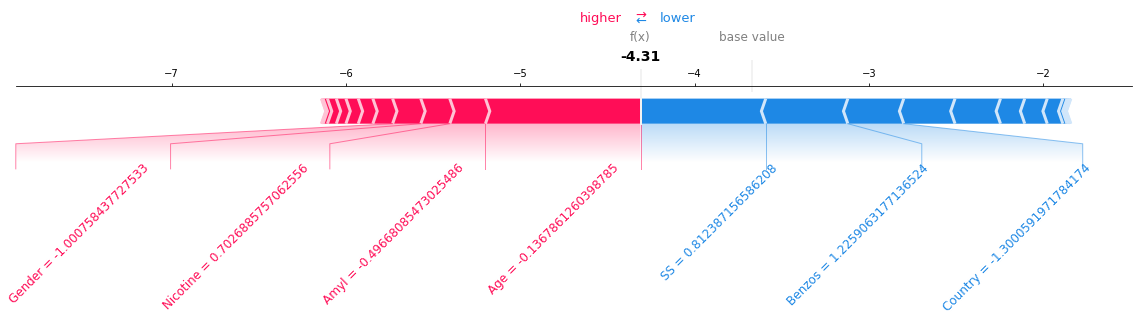

In [ ]:
# Влияние признаков для одного ошибочно классифицированного объекта
shap.force_plot(
    VSA_LGBM_explainer.expected_value[1],
    VSA_LGBM_shap_values[1][VSA_LGBM_error_index[4]],
    VSA_params_LGBM['X_test'].iloc[[VSA_LGBM_error_index[4]]],
    text_rotation=45,
    matplotlib = True)

Для улучшения предсказаний попробуем подобрать гиперпараметры при помощи optuna, а так же сделаем ансамблевое обучение из 3х лучших моделей.

In [ ]:
#best_params = {"LogReg": {}, "KNN": {}, "LGBM": {}}

def objective(trial):
    classifier_name = trial.suggest_categorical(
        "classifier", ["LogReg", "KNN", "LGBM"])

    if classifier_name == "LogReg":
        C = trial.suggest_float('C', 1e-10, 1e10, log=True)
        max_iter = trial.suggest_float('max_iter', 10, 10000)
        classifier_obj = LogisticRegression(C=C, random_state=777)

    elif classifier_name == "KNN":
        n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
        classifier_obj = KNeighborsClassifier(
        n_neighbors=n_neighbors)

    elif classifier_name == "LGBM":
        params = {
            'metric': 'auc',
            'random_state': 777,
            'n_estimators': trial.suggest_int('n_estimators', 1000, 10000),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
            'subsample': trial.suggest_float('subsample', 0.4, 1.0),
            'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
            'max_depth': trial.suggest_int('max_depth', 2, 30, log=True),
        }
        classifier_obj = LGBMClassifier(**params)

    # Находим самый лучший f1_score среди самых сбалансированных признаков
    total_f1_score = 0
    for col in ['Benzos', 'Legalh', "Ecstasy"]:
      X_train, X_test, y_train, y_test = data_preprocessing(data, col)
      classifier_obj.fit(X_train, y_train)
      y_pred = classifier_obj.predict(X_test)
      score = f1_score(y_test, y_pred)
      if total_f1_score < score:
        total_f1_score = score
      
    #best_params[classifier_name] = classifier_obj.get_params()

    return total_f1_score

In [ ]:
study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=100, reduction_factor=3
    )
)
study.optimize(objective, n_trials=100)

In [ ]:
best_params = {
    "LGBM": {
        'n_estimators': 8071,
        'reg_alpha': 0.20179401749185202,
        'reg_lambda': 0.0012709718786119992,
        'colsample_bytree': 0.8125185880338495,
        'subsample': 0.9819891861124374,
        'learning_rate': 0.0011042772664675551,
        'max_depth': 2
    },

    "KNN": {'n_neighbors': 27},
    
    "LogisticRegression": {
        'C': 1425.5214158538388,
        'max_iter': 5437.824414050639
    }
}

In [ ]:
best_models = {
    "LogisticRegression" : LogisticRegression(**best_params['LogisticRegression']),

    "KNN" : KNeighborsClassifier(**best_params['KNN']),

    "LGBM" : LGBMClassifier(**best_params['LGBM'])
}

In [ ]:
# Создаем пустой датафрейм для предсказаний и метрик
drug_preds = np.zeros((len(X_test), len(data.columns[12:])))
drug_preds = pd.DataFrame(drug_preds, columns=data.columns[12:])
folds = 10
index = pd.MultiIndex.from_product([data.columns[12:],
                                                        ['LogisticRegression', 'KNN', 'LGBM', "LGBM + LogReg + KNN"]],
                                                         names=['Drug', 'Classifier'])
bagging_valid_scores = pd.DataFrame({
    'F1-score': np.zeros(len(index)),

}, index=index)

for col_num, col in enumerate(data.columns[12:]):

    # Разбиваем выборку
    X_train, X_test, y_train, y_test = data_preprocessing(data, col, non_scale=True)

    preds = np.zeros(len(X_test))

    for clf_num, (key, classifier) in enumerate(best_models.items()):
        start = time.time()

        cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=777)

        f1_scores = np.zeros(folds)

        for fold, (train_idx, valid_idx) in enumerate(cv.split(X_train, y_train)):
            # Разбиваем выборку на тренировочную и валидационную
            X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
            y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

            # Нормируем выборки
            scaler = StandardScaler()
            scaler.fit(X_train_fold)
            X_train_fold = scaler.transform(X_train_fold)
            X_valid_fold = scaler.transform(X_valid_fold)

            # Обучаем модель
            clf = classifier
            clf.fit(X_train_fold, y_train_fold)

            # Делаем предсказания и записываем метрику
            y_pred_fold = clf.predict(X_valid_fold)
            preds += clf.predict_proba(X_test)[:, 1]
            f1_scores[fold] = f1_score(y_valid_fold, y_pred_fold)

        # Фиксируем время обучения
        stop = time.time()
        # Добавляем метрику для отдельной модели
        bagging_valid_scores.loc[(col, key), 'F1-score'] = np.mean(f1_scores)
        # Выводим в консоль модель, время обучения на 10-ти фолдах и метрику
        print('Модель:', key)
        print('Время обучения (сек):', np.round((stop - start), 2))
        print('F1-scores для модели:', np.mean(f1_scores))
        print('')

        # Добавляем столбец с предсказаниями в датафрейм
        col_key = f"{col}_{key}"
        drug_preds[col_key] = preds / folds

    # Добавляем столбец с усредненными предсказаниями
    col_keys = [f"{col}_{key}" for key in best_models.keys()]
    drug_preds[col] = drug_preds[col_keys].mean(axis=1)

    # Сохраняем промежуточный f1-score
    col_f1 = f1_score(y_test, drug_preds[col] > 0.5)
    bagging_valid_scores.loc[(col, "LGBM + LogReg + KNN"), 'F1-score'] = col_f1
    print(f"F1-score для признака {col}: {col_f1}")
    print('-----------------------------------------------------------------------------------')


Модель: LogisticRegression
Время обучения (сек): 0.48
F1-scores для модели: 0.760648345876908

Модель: KNN
Время обучения (сек): 0.77
F1-scores для модели: 0.7500450795071206

Модель: LGBM
Время обучения (сек): 24.21
F1-scores для модели: 0.7733446464160376

F1-score для признака Amphet: 0.7025089605734767
-----------------------------------------------------------------------------------
Модель: LogisticRegression
Время обучения (сек): 0.25
F1-scores для модели: 0.532984812814081

Модель: KNN
Время обучения (сек): 0.46
F1-scores для модели: 0.4601702151445412

Модель: LGBM
Время обучения (сек): 23.3
F1-scores для модели: 0.5688810467585347

F1-score для признака Amyl: 0.5047169811320754
-----------------------------------------------------------------------------------
Модель: LogisticRegression
Время обучения (сек): 0.22
F1-scores для модели: 0.6982777727895482

Модель: KNN
Время обучения (сек): 0.46
F1-scores для модели: 0.6649461221629454

Модель: LGBM
Время обучения (сек): 22.41
F

In [ ]:
drug_preds.sample(5)

,Amphet,Amyl,Benzos,Cannabis,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,VSA,Cocaine,Amphet_LogisticRegression,Amphet_KNN,Amphet_LGBM,Amyl_LogisticRegression,Amyl_KNN,Amyl_LGBM,Benzos_LogisticRegression,Benzos_KNN,Benzos_LGBM,Cannabis_LogisticRegression,Cannabis_KNN,Cannabis_LGBM,Ecstasy_LogisticRegression,Ecstasy_KNN,Ecstasy_LGBM,Heroin_LogisticRegression,Heroin_KNN,Heroin_LGBM,Ketamine_LogisticRegression,Ketamine_KNN,Ketamine_LGBM,Legalh_LogisticRegression,Legalh_KNN,Legalh_LGBM,LSD_LogisticRegression,LSD_KNN,LSD_LGBM,Meth_LogisticRegression,Meth_KNN,Meth_LGBM,Mushrooms_LogisticRegression,Mushrooms_KNN,Mushrooms_LGBM,Nicotine_LogisticRegression,Nicotine_KNN,Nicotine_LGBM,VSA_LogisticRegression,VSA_KNN,VSA_LGBM,Cocaine_LogisticRegression,Cocaine_KNN,Cocaine_LGBM
25,1.329163,0.413197,0.723563,1.702695,1.897852,0.015794,1.017223,1.264633,1.141557,0.067938,0.927153,1.627123,0.109181,1.457647,0.683531,1.327976,1.975982,0.223761,0.438575,0.577256,0.456893,0.723560,0.990234,0.982748,1.749414,2.375924,0.958793,1.877311,2.857453,0.009254,0.009254,0.028873,0.462856,0.981375,1.607439,0.555807,1.333585,1.904508,0.605001,1.105001,1.714668,0.036620,0.069953,0.097241,0.546128,0.938720,1.296610,0.854233,1.609788,2.417348,0.058901,0.121864,0.146779,0.765558,1.439632,2.167751
136,1.366596,0.869007,0.826324,1.957064,0.605601,0.085808,0.061584,0.477789,0.017263,0.600088,1.605137,1.849160,0.096557,1.832263,0.717541,1.384207,1.998040,0.378412,0.841375,1.387233,0.494687,0.828020,1.156266,0.997972,1.938713,2.934508,0.439004,0.661226,0.716573,0.009958,0.109958,0.137507,0.059500,0.059500,0.065751,0.323107,0.493477,0.616782,0.016032,0.016032,0.019723,0.271675,0.601304,0.927284,0.872187,1.575891,2.367335,0.897397,1.864064,2.786018,0.064689,0.098022,0.126959,0.925653,1.818245,2.752890
139,0.547604,0.563438,1.486517,1.991558,0.324785,0.136659,0.102023,0.442739,0.073927,0.081728,0.099620,1.847949,0.069509,0.674410,0.398882,0.539623,0.704307,0.334721,0.508795,0.846799,0.816345,1.401530,2.241676,0.993817,1.993817,2.987039,0.299904,0.333237,0.341215,0.014814,0.188888,0.206274,0.074524,0.107857,0.123686,0.333495,0.466828,0.527895,0.034455,0.090010,0.097316,0.064401,0.068105,0.112677,0.093713,0.093713,0.111435,0.943098,1.831987,2.768763,0.017903,0.084569,0.106055,0.493850,0.708665,0.820716
403,1.453499,0.697320,1.585601,1.362291,1.115629,0.096569,0.842466,1.330379,0.024368,0.426593,1.684956,1.706329,0.020236,0.859606,0.764983,1.461279,2.134235,0.429554,0.748072,0.914333,0.783285,1.524026,2.449491,0.867144,1.411588,1.808141,0.724496,1.072644,1.549747,0.024816,0.124816,0.140075,0.448861,0.882194,1.196343,0.796732,1.318954,1.875450,0.022337,0.022337,0.028431,0.155106,0.443995,0.680679,0.805589,1.675959,2.573320,0.864820,1.701857,2.552309,0.017856,0.017856,0.024996,0.543050,0.931939,1.103830
538,1.523467,1.186125,1.097651,0.985734,1.864214,0.028098,0.044638,1.016741,0.044713,0.190310,1.258486,1.621247,0.172353,0.756794,0.751607,1.551607,2.267188,0.622579,1.292950,1.642846,0.550692,1.098840,1.643421,0.731556,1.035260,1.190386,0.959760,1.826427,2.806457,0.003993,0.037327,0.042974,0.041052,0.041052,0.051810,0.542376,1.016450,1.491396,0.042861,0.042861,0.048415,0.060751,0.227417,0.282762,0.613965,1.299150,1.862343,0.827445,1.627445,2.408853,0.107049,0.173716,0.236295,0.548515,0.789256,0.932611


In [ ]:
bagging_valid_scores = bagging_valid_scores.join(valid_scores.loc[(slice(None), ['KNN', "LGBM", "LogisticRegression"]), 'F1-score_test'], how='outer')

In [ ]:
bagging_valid_scores

F1-score  F1-score_test
Drug      Classifier                                  
Amphet    KNN                  0.750045       0.754177
          LGBM                 0.773345       0.742169
          LGBM + LogReg + KNN  0.702509            NaN
          LogisticRegression   0.760648       0.757282
Amyl      KNN                  0.460170       0.487562
          LGBM                 0.568881       0.531250
          LGBM + LogReg + KNN  0.504717            NaN
          LogisticRegression   0.532985       0.536842
Benzos    KNN                  0.664946       0.712963
          LGBM                 0.704490       0.753425
          LGBM + LogReg + KNN  0.662757            NaN
          LogisticRegression   0.698278       0.739606
Cannabis  KNN                  0.873586       0.870787
          LGBM                 0.910432       0.902013
          LGBM + LogReg + KNN  0.803383            NaN
          LogisticRegression   0.906055       0.904000
Cocaine   KNN                  0.767721       0.727735
          LGBM                 0.793893       0.789474
          LGBM + LogReg + KNN  0.629518            NaN
          LogisticRegression   0.788836       0.806931
Ecstasy   KNN                  0.831562       0.839827
          LGBM                 0.837208       0.847458
          LGBM + LogReg + KNN  0.728155            NaN
          LogisticRegression   0.847643       0.842795
Heroin    KNN                  0.499261       0.477876
          LGBM                 0.613175       0.556522
          LGBM + LogReg + KNN  0.520325            NaN
          LogisticRegression   0.643448       0.521739
Ketamine  KNN                  0.584919       0.519608
          LGBM                 0.538488       0.564103
          LGBM + LogReg + KNN  0.589971            NaN
          LogisticRegression   0.607472       0.594059
LSD       KNN                  0.790071       0.751479
          LGBM                 0.792409       0.757225
          LGBM + LogReg + KNN  0.775904            NaN
          LogisticRegression   0.790843       0.780059
Legalh    KNN                  0.816713       0.783505
          LGBM                 0.806819       0.795960
          LGBM + LogReg + KNN  0.746269            NaN
          LogisticRegression   0.808144       0.796715
Meth      KNN                  0.564832       0.648649
          LGBM                 0.626284       0.646018
          LGBM + LogReg + KNN  0.652778            NaN
          LogisticRegression   0.621884       0.652361
Mushrooms KNN                  0.791888       0.772182
          LGBM                 0.796443       0.791878
          LGBM + LogReg + KNN  0.749077            NaN
          LogisticRegression   0.807450       0.796117
Nicotine  KNN                  0.837219       0.822309
          LGBM                 0.852035       0.838046
          LGBM + LogReg + KNN  0.803383            NaN
          LogisticRegression   0.847245       0.842912
VSA       KNN                  0.271786       0.314815
          LGBM                 0.330406       0.277778
          LGBM + LogReg + KNN  0.413333            NaN
          LogisticRegression   0.430474       0.250000

Подборка гиперпараметров и обучение на 10-фолдах немного улучшили метрику, однако объединение моделей показывает результат хуже. Для хорошо сбалансированных признаков(Benzos, Legalh, Ecstasy, Nicotine, Cocaine) лучше всего работает LGBM. Для плохо сбалансированных признаков (Heroin, VSA, Ketamine, Amyl) лучше работает LogisticRegression.

In [ ]:
round(data[data.columns[12:]].sum()/len(data)*100, 1).sort_values(ascending=False)

Cannabis     67.1
Nicotine     67.1
Benzos       40.8
Legalh       40.4
Ecstasy      39.8
Cocaine      37.1
Mushrooms    36.8
Amphet       36.0
LSD          29.5
Meth         22.1
Amyl         19.6
Ketamine     18.6
VSA          12.2
Heroin       11.2
dtype: float64

### **Задание №4**. Предположим, что мы построили рекомендательную систему, и ожидаем, что средний чек клиента вследствие этого должен вырасти. Мы провели AB-тест и собрали данные по контрольной и тестовой группе. Предложите и проведите статистический тест, который можно применить к этим данным.

В процессе выполнения задания разрешено пользоваться библиотеками scipy и statsmodels.

In [ ]:
import numpy as np

# Сгенерируем данные для задачи
control = np.random.lognormal(mean=5, sigma=2, size=(100000,))
test = np.random.lognormal(mean=5.04, sigma=2, size=(100000,))

In [ ]:
from scipy.stats import shapiro, levene, ttest_ind

# Проверяем нормальность распределения выборок
stat, p = shapiro(control)
print('Распределениие в выборке Control:', 'stat=%.3f, p=%.3f' % (stat, p))
stat, p = shapiro(test)
print('Распределениие в выборке Test:', 'stat=%.3f, p=%.3f' % (stat, p))

# Проверяем равенство дисперсий
stat, p = levene(control, test)
print('Levene test: stat=%.3f, p=%.3f' % (stat, p))

Распределениие в выборке Control: stat=0.115, p=0.000
Распределениие в выборке Test: stat=0.072, p=0.000
Levene test: stat=1.804, p=0.179


In [ ]:
# Так как тест Шапиро-Уилка показал p-value < 0.05, нулевая гипотеза о нормальности распределения отвергается
# Так как тест Левена показал p-value > 0.05, нулевая гипотеза о равенстве дисперсий отвергается
# Применим тест Манна-Уитни
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(control, test)
print('Mann-Whitney test: stat=%.3f, p=%.3f' % (stat, p))

Mann-Whitney test: stat=4940132817.000, p=0.000


Так как тест Манна-Уитни показал p-value < 0.05, нулевая гипотеза об отсутствии статистически значимой разницы между выборками отвергается. Следовательно, рекомендательная система влияет на средний чек клиента.

### **Задание №4 (*)**. В прошлом задании мы улавливали статистически значимое различие в средних в 0.04 единицы на выборке из 100000 клиентов. Насколько больше нам требуется собрать клиентов, чтобы уловить различие в 0.02?

In [ ]:
from statsmodels.stats.power import TTestIndPower
# Сначала найдем мощность теста для выборки на 100000 клиентов
alpha = 0.05
n1 = n2 = 100000
m = 0.04

power = TTestIndPower().power(effect_size=m, nobs1=n1, alpha=alpha, ratio=n2/n1)

# Затем находим число клиентов для той же мощности теста и различие в 0.02
m = 0.02
n = TTestIndPower().solve_power(effect_size=m, alpha=alpha, power=power, ratio=1)

print('Размер выборки:', round(n))

Размер выборки: 500000
